### ML Tests
_____

In [2]:
from gaitlink.lr_detection import LR_detector
from sklearn import neighbors

from gaitlink.data import load_mobilised_matlab_format, get_all_lab_example_data_paths
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

# Load some example data
subject = ("HA", "001")

all_example_data_paths = get_all_lab_example_data_paths()
example_participant_path = all_example_data_paths[subject]
data_with_reference_stereo = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="Stereophoto")
data_with_reference_indip = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")

test_list = list(data_with_reference_stereo.keys())

example_participant_path = all_example_data_paths[subject]
data_with_reference = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")
test_list = list(data_with_reference_stereo.keys())

# which test do you want to use?
test_no = 2
imu_data = data_with_reference[test_list[test_no]].imu_data['LowerBack']
sampling_rate = data_with_reference[test_list[test_no]].metadata.sampling_rate_hz
event_list = data_with_reference[test_list[test_no]].reference_parameters['lwb'] 

# Requirements for the LR detector...
detector = LR_detector(sampling_rate = sampling_rate,
                       approach = 'ml')

AttributeError: 'MobilisedTestData' object has no attribute 'reference_parameters'

1. Testing the `pretrained` functionality, i.e. using the pre-trained classifiers saved in `pretrained_models` folder.

In [53]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                pretrained = True,
                patient_group = "hc", # change this accordingly, read the docs!
                verbose = True
                )
# note: if 'classifier_name' is specified and the pretrained state is set to False, then `patient_group`` is not relevant anymore.

Using pretrained models...
Predicting L/R Labels...
Done!


c:\Users\mer20as\Documents\PhD_Repos\gaitlink\.venv\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Can we get the settings used for the classifier?

In [54]:
# print the classifier used for L/R prediction
print(detector.trained_model)

# get the parameters of the trained model:
detector.trained_model.get_params()

SVC(C=10, kernel='linear')


{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Plot the decision boundary

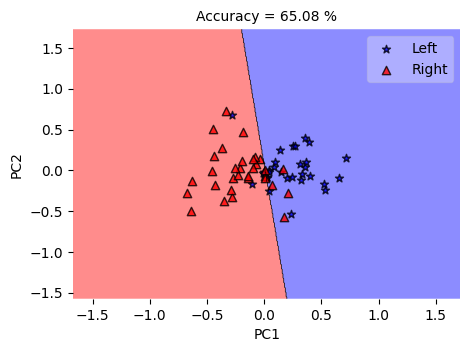

In [55]:
def plot_decision_boundaries(detector):
    clf = detector.trained_model
    x_train = detector.x_train
    y_train = detector.y_train

    pca = PCA(n_components = 2)
    x_train_pca = pca.fit_transform(x_train)
    clf.fit(x_train_pca, y_train.ravel())

    plt.figure(figsize = (5, 3.5))
    ax = plot_decision_regions(x_train_pca, y_train.ravel(), clf = clf,
                        legend = 2,
                        colors = "blue,red",
                        markers = "*^")
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.title(f'Accuracy = {metrics.accuracy_score(y_train, detector.y_pred.ravel()) * 100 :.2f} %', size=10)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, 
            ['Left', 'Right'],
            framealpha=0.3, scatterpoints=1)
    
plot_decision_boundaries(detector)

2. Testing the grid-search functionality using all the available classifiers. This will return the model with the best accuracy.

Starting model training...
No model selected. Grid search will be performed and the model achieving highest accuracy will be returned.
Predicting L/R Labels...
Done!


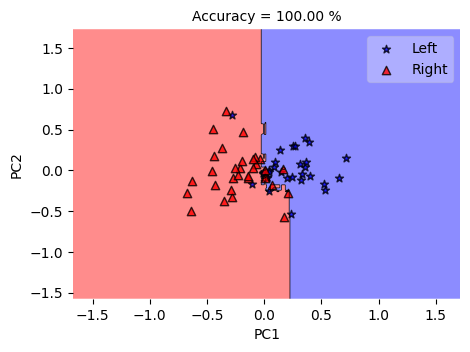

In [57]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                pretrained = False,
                verbose = True)

plot_decision_boundaries(detector)
# classic example ov overfitting over so few datapoints... :))

What was the best classifier?

In [64]:
detector.trained_model

SVC(C=1, gamma=1)

3. Testing the gid-search functionality over one specific classifier. In this case we are using `classifier_name` = `svm_rbf`

Starting model training...
Training SVM model with rbf kernel...
Training complete!
Predicting L/R Labels...
Done!


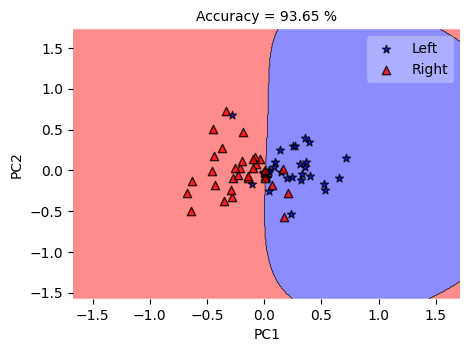

In [62]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                pretrained = False,
                classifier_name = 'svm_rbf',
                verbose = True)

plot_decision_boundaries(detector)

4. Testing the user specified grid-search parameters.


Starting model training...
Training SVM model with rbf kernel...
Training complete!
Predicting L/R Labels...
Done!


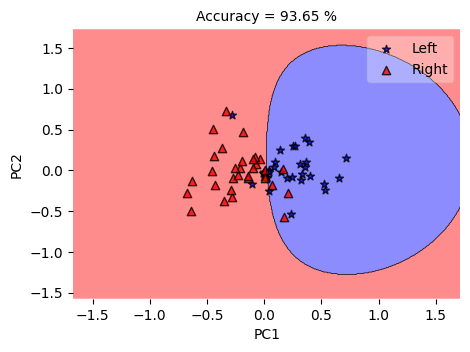

In [67]:
grid = {'C': [0.5, 0.75, 0.9, 1, 1.1, 1.5],
        'gamma': [3, 2, 1.5, 1.25, 1.1, 1, 0.9, 0.75],
        'kernel': ['rbf']}

lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                pretrained = False,
                patient_group = "hc",
                classifier_name = 'svm_rbf',
                grid = grid, # this should be a dictionary
                verbose = True
                )

plot_decision_boundaries(detector)

5. Testing user-specified classifiers. This will overwrite all training capabilities.

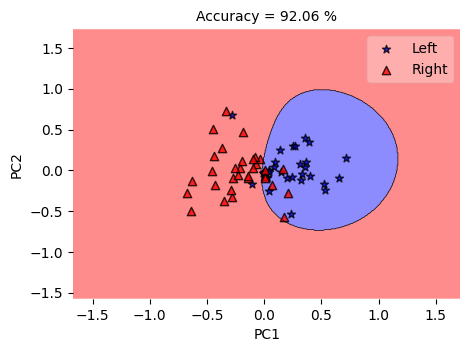

In [68]:
from sklearn import svm

test_clf = svm.SVC(C =  0.88, gamma = 2.39, kernel = 'rbf')

# x  = np.array([10, 2, 11, 3, 12, 1.5])[:, None]
# y = np.array([0, 1, 0, 1, 0, 1])[:, None]
# test_model.fit(x, y)
# test_model.predict(x)

detector_clf = LR_detector(sampling_rate = sampling_rate,
                       approach = 'ml')

lr_list = detector_clf.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                classifier = test_clf
                )

plot_decision_boundaries(detector_clf)

In [75]:
# reverting to the highest accuracy model... using grid search over all available classifiers

lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                pretrained = False,
                verbose = False)

ground_truth = [event_list[seq]['InitialContact_LeftRight'] for seq in range(len(event_list))]
print('Ground truth: \n', np.hstack(ground_truth))
print('Predictions: \n', np.hstack(lr_list))

print('Accuracy: ', metrics.accuracy_score(np.hstack(ground_truth), np.hstack(lr_list)))


Ground truth: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Right' 'Left' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right'
 'Left' 'Right' 'Left' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right'
 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right'
 'Left' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right'
 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Predictions: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Right' 'Left' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Left' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Right'
 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Right' 'Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left'
 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Accurac

### McCamley tests from here on...
______

In [77]:
subject = ("HA", "001")

all_example_data_paths = get_all_lab_example_data_paths()
example_participant_path = all_example_data_paths[subject]
data_with_reference_stereo = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="Stereophoto")
data_with_reference_indip = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")

test_list = list(data_with_reference_stereo.keys())

example_participant_path = all_example_data_paths[subject]
data_with_reference = load_mobilised_matlab_format(example_participant_path / "data.mat", reference_system="INDIP")
test_list = list(data_with_reference_stereo.keys())

test_no = 1

imu_data = data_with_reference[test_list[test_no]].imu_data['LowerBack']
sampling_rate = data_with_reference[test_list[test_no]].metadata.sampling_rate_hz
event_list = data_with_reference[test_list[test_no]].reference_parameters['lwb']

In [81]:
detector = LR_detector(sampling_rate = sampling_rate,
                       approach= 'mccamley') 

# note: there is also a McCamley-original option

1. Testing the Vertical axis approach.

In [89]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                axis_config = 'Vertical')
# there are no extra parameters here. The additional consistency check does not work as intended, and here it was not included in this version...

ground_truth = [event_list[seq]['InitialContact_LeftRight'] for seq in range(len(event_list))]

print('Ground truth: \n', np.hstack(ground_truth))
print('Predictions: \n', np.hstack(lr_list))

print(f'\nAccuracy: {metrics.accuracy_score(np.hstack(ground_truth), np.hstack(lr_list)) * 100:.2f}%')

Ground truth: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Predictions: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Accuracy: 100.0%


2. Testing the Anterior-Posterior axis approach.

In [96]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                axis_config = 'Anterior-Posterior')
# there are no extra parameters here. The additional consistency check does not work as intended, and here it was not included in this version...

ground_truth = [event_list[seq]['InitialContact_LeftRight'] for seq in range(len(event_list))]

print('Ground truth: \n', np.hstack(ground_truth))
print('Predictions: \n', np.hstack(lr_list))

print(f'\nAccuracy: {metrics.accuracy_score(np.hstack(ground_truth), np.hstack(lr_list)) * 100:.2f}%')

Ground truth: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Predictions: 
 ['Right' 'Right' 'Left' 'Right' 'Left' 'Right' 'Right' 'Right' 'Right']

Accuracy: 66.67%


3. Testing the Combined axis approach.

In [98]:
lr_list = detector.predict(imu_data = imu_data,
                event_list = event_list,
                reference_data = True,
                axis_config = 'Combined')
# there are no extra parameters here. The additional consistency check does not work as intended, and here it was not included in this version...

ground_truth = [event_list[seq]['InitialContact_LeftRight'] for seq in range(len(event_list))]

print('Ground truth: \n', np.hstack(ground_truth))
print('Predictions: \n', np.hstack(lr_list))

print(f'\nAccuracy: {metrics.accuracy_score(np.hstack(ground_truth), np.hstack(lr_list)) * 100:.2f}%')

Ground truth: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']
Predictions: 
 ['Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left' 'Right' 'Left']

Accuracy: 100.00%


Text(0.5, 1.0, 'Predicted L/R ICs')

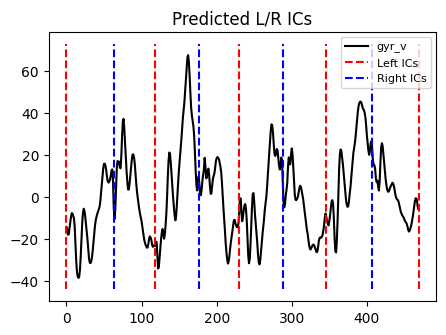

In [137]:
# extract the GSD data and plot predictions...

data_list, walking_type_label, sequence_no,  ic_list, reference_lr_list = detector.extract_sequence_data(imu_data, event_list, reference_data=True)

# plotting
plt.figure(figsize = (5, 3.5))
plt.plot(data_list[0][:, 0], color = 'black', label = 'gyr_v')

left_ind = [ic_list[0][ind] for ind in range(len(ic_list[0])) if lr_list[0][ind] == 'Left']
right_ind = [ic_list[0][ind] for ind in range(len(ic_list[0])) if lr_list[0][ind] == 'Right']

ax = plt.gca()
ylimits = ax.get_ylim()

plt.vlines(left_ind,
           ymin = ylimits[0],
           ymax = ylimits[1],
           color = 'red',
           linestyles = 'dashed',
           label = 'Left ICs' )

plt.vlines(right_ind,
           ymin = ylimits[0],
           ymax = ylimits[1],
           color = 'blue',
           linestyles = 'dashed',
           label = 'Right ICs')

plt.legend(fontsize = 8)
plt.title('Predicted L/R ICs')